In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from numba import jit
# from numba.experimental import jitclass

from InputSimulator import make_input, make_pattern_presentation_array, copy_and_paste_jittered_pattern
from InputSimulator import triple_input_runtime, remove_close_spikes, add_noise

In [2]:
# pretty print matrix A
# original code!
def pprint(A):
    if A.ndim==1:
        print(np.array_str(A, precision=2, suppress_small=True))
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA)+' '*(w1-len(str(AAA))+1),end='')
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='')
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

# pretty print matrix A
def pprint(A, precision=2):
    A = np.around(A, decimals=precision)
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA) +' '*(w1-len(str(AAA))+1),end='') # str(AAA)
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='') # str(AA[-1])
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

## Generating Input

In [3]:
tripling = False
is_continuous = False
runduration = 50 # [second]
dt = 0.001 # [second]
number_neurons = 2000
number_pat = 1000  # number of neurons that take part in the pattern presentation


T = len(np.arange(dt, runduration, dt))

max_time_wo_spike = 0.05 # [second]
min_rate, max_rate = 0 , 90
max_change_speed = max_rate / max_time_wo_spike # 90/0.05 = 1800 (max_S in paper)
patternlength = 0.05 # [second]
# pattern_freq = 0.5
pattern_freq = 0.25


max_rate_add = 10
min_rate_add = 10
max_time_wo_spike_add = 1000
max_change_speed_add = 0

spike_del = 0
jitter_sd = 1

In [4]:
indices, times = make_input(min_rate, max_rate, max_time_wo_spike, max_change_speed, runduration, number_neurons, dt, is_continuous)
position_copypaste = make_pattern_presentation_array(runduration, patternlength, pattern_freq)

In [5]:
def plot_input(times, indices, params, times_pattern=None, indices_pattern=None, model= None,):
    plt.figure(figsize=(12,5))
    start_time = params['start_time']
    end_time = params['end_time']
    start_index = params['start_index']
    end_index = params['end_index']

    sampletimes = times[(times < end_time) & (indices < end_index) & (times > start_time) & (indices > start_index)]
    sampleindices = indices[(times < end_time) & (indices < end_index) & (times > start_time) & (indices > start_index)]

    
    intervals = np.arange(start_time, end_time+0.01, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < end_time) & (indices_pattern < end_index) & (times_pattern > start_time) & (indices_pattern > start_index)]
        sampleindicespattern = indices_pattern[(times_pattern < end_time) & (indices_pattern < end_index) & (times_pattern > start_time) & (indices_pattern > start_index)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron number')
    plt.show()

params = {'start_time' : 0.0,
        'end_time' : 1.0,
        'start_index' : 0,
        'end_index' : 600,}

def plot_potential(start_time, end_time, model, position_copypaste):
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(start_time,end_time,dt), model.potential_rec[int(start_time/dt):int(end_time/dt)])
    plt.axhline(0, linestyle=':', color='black')
    plt.axhline(model.threshold, linestyle='--', color='red')
    
    pattern_time = np.where((position_copypaste == 1))[0] * 50 * dt
    ind = np.where((pattern_time >= start_time) & (pattern_time <= end_time))
    pattern_time[ind]
    for i in pattern_time[ind]:
        plt.axvspan(i, i + patternlength, facecolor='gray', alpha=0.7)

    plt.xlabel('Time (s)')
    plt.ylabel('Membrane Potential (arbitrary units)')
    plt.show()

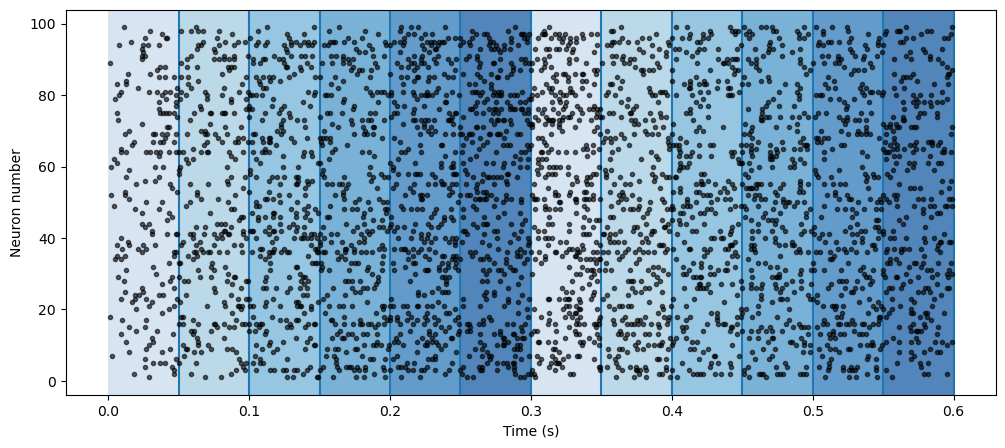

In [113]:
params = {'start_time' : 0.0,
        'end_time' : 0.6,
        'start_index' : 0,
        'end_index' : 100,}

plot_input(times, indices, params)

In [6]:
indices, times, (indices_pattern, times_pattern) = copy_and_paste_jittered_pattern(times, indices, position_copypaste, patternlength, jitter_sd, spike_del,number_pat)
indices_add, times_add = make_input(min_rate_add, max_rate_add, max_time_wo_spike_add,
                                max_change_speed_add, runduration, number_neurons, dt, is_continuous)
times, indices = add_noise(times, indices, times_add, indices_add)
if tripling and runduration > 300:
        times, indices = triple_input_runtime(times, indices)
        position_copypaste = np.concatenate((position_copypaste, position_copypaste, position_copypaste))
# times, indices = remove_close_spikes(times, indices, dt)
indices = indices.astype(int)

In [7]:
def get_dataset( times, indices, initial_weight):
    spike_train = np.zeros((number_neurons, int(runduration/dt)))
    for time, index in zip(times, indices):
        time = int(time/dt)
        if time == spike_train.shape[1]:
            break
        spike_train[index,time] = 1
    weight = np.ones((number_neurons,1)) * initial_weight
    return spike_train, weight

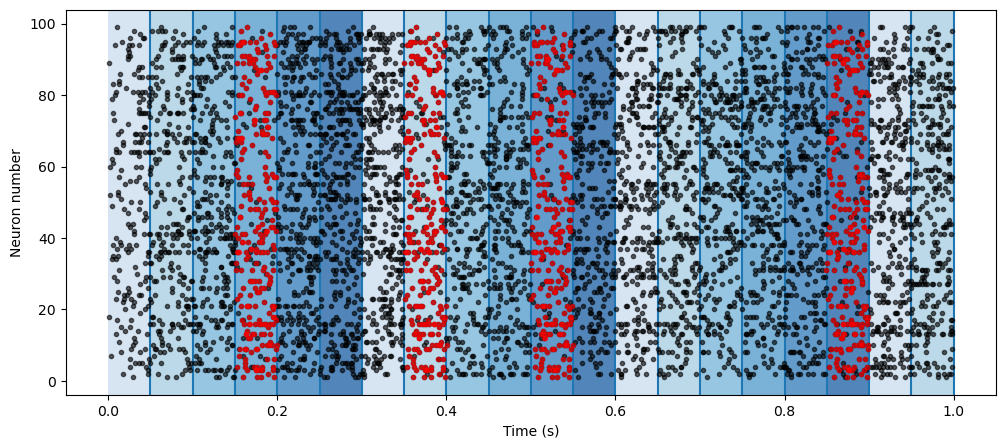

In [114]:
params = {'start_time' : 0.0,
        'end_time' : 1.0,
        'start_index' : 0,
        'end_index' : 100,}

plot_input(times, indices, params, times_pattern, indices_pattern)

In [10]:
class STDP:
    def __init__(self, A_pos, B, tau_pos, tau_neg, verbose=False) -> None:
        """_summary_

        Args:
            A_pos (_type_): _description_
            B (_type_): _description_
            tau_pos (_type_): _description_
            tau_neg (_type_): _description_
        """
        self.A_pos = A_pos
        self.B = B
        self.A_neg = - B * self.A_pos
        self.tau_pos = tau_pos
        self.tau_neg = tau_neg
        self.verbose = verbose

    def plot_stdp_(self, range, stepsize):
        r = np.arange(-range,range, stepsize)
        l = len(r)
        half = int(l/2)
        dw = [self.ltp(val) if val<0 else self.ltd(val) for val in r ]
        # de_neg = [self.ltd(val) if val<0 for val in r]
        plt.plot(r[:half], dw[:half], '.r')
        plt.plot(r[half:], dw[half:], '.b')
        plt.axhline(0, linestyle=':', color='black')
        plt.axvline(0, linestyle=':', color='black')
        plt.xlabel('T_pre - T_post (ms)')
        plt.ylabel('dw')
    
    def ltp(self, delta_t):
        return self.A_pos * np.exp(delta_t/self.tau_pos)

    def ltd(self, delta_t):
        return self.A_neg * np.exp(-delta_t/self.tau_neg)
    
    def do_ltp(self,stdp_window, t, dt):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_last_spike_time = np.full((n, 1), -np.inf)
        afferent_last_spike_time[spike_row_index[0], 0] = spike_row_index[1]
        afferent_last_spike_time *= dt
        delta_t = afferent_last_spike_time - (window_length) * dt
        dw = self.ltp(delta_t)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j, t_i): 
        dw = np.zeros((n,1))
        if t_i > 0:
            t= t_j - t_i
            ltd_val = self.ltd(delta_t= t)
            dw[list(first_time_spiked),:] = ltd_val
        return dw

In [ ]:
class BaseModel:
    def plot_kernel_(self, kernel, range, step_size):
        r = np.arange(0,range,step_size)
        if kernel == 'eta':
            plt.plot(r/self.dt,self.eta_kernel(r), label=r'\eta kernel')
            plt.plot(r/self.dt,self.eta_kernel(r), 'xr')
            plt.axhline(0, linestyle='-', color='black')
            plt.axhline(min(self.eta_kernel(r)), linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(max(self.eta_kernel(r)), linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\eta (t - t_j)$ kernel')
            plt.legend()
            
        elif kernel == 'eps':
            plt.plot(r/self.dt, self.eps_kernel(r), '--k', label=r'$\varepsilon$ kernel')
            plt.plot(r/self.dt,self.eps_kernel(r), 'xr')
            plt.axhline(0, linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(1, linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\varepsilon (t - t_j)$ kernel')
            plt.legend()
        else:
            raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
    def show_epsilon_matrix_(self, size):
        def print_epsilon_matrix(matrix):
            max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
            column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
            for row in matrix:
                print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
        matrix = np.empty((2,size), dtype='U40')

        for i in range(size):
            matrix[0, i] = f'epsilon({size-i}ms)'
            matrix[1, i] = self.eps_kernel((size-i)*self.dt)
        print_epsilon_matrix(matrix)
    
    def plot_membrane_potential_(self, spike_train):
        plt.figure(figsize=(8,6))
        plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
        spikes = np.where(spike_train ==1)[1]
        for spk in spikes:
            plt.axvline(spk, linestyle='-.', color='gray')
        plt.axhline(self.threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')

In [25]:
# @jitclass(spec)
class SRM():
    def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, A_pos, B, tau_pos, tau_neg) -> None:
        self.threshold = threshold
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.dt = dt
        self.window_size = window_size
        self.tref = tref

        self.A_pos= A_pos
        self.B=B
        self.tau_pos=tau_pos
        self.tau_neg=tau_neg
        self.A_neg = - B * self.A_pos
        
        # initial state of the neuron
        self.last_spike_time = - 10e6
        self.spike_rec = []
        self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_not_spiked_yet = None

        ##############
        self.w_sample = None
        ##############

    def do_ltp(self,stdp_window):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_last_spike_time = np.full((n, 1), -np.inf)
        afferent_last_spike_time[spike_row_index[0], 0] = spike_row_index[1]
        afferent_last_spike_time *= self.dt
        delta_t = afferent_last_spike_time - (window_length) * self.dt
        dw = self.ltp(delta_t)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j):
        """
        self.last_spike_time = t_i
        """ 
        dw = np.zeros((n,1))
        if self.last_spike_time > 0:
            t= t_j - self.last_spike_time
            ltd_val = self.ltd(delta_t= t)
            dw = first_time_spiked * ltd_val
        return dw
    
    def ltp(self, delta_t):
        return self.A_pos * np.exp(delta_t/self.tau_pos)

    def ltd(self, delta_t):
        return self.A_neg * np.exp(-delta_t/self.tau_neg)

    def eps_kernel(self, s):
        """"
        s = t - t_j 
        time difference between thre current time and spike time of presynaptic neuron (t_j)
        K is chosen such that the maximum value of epsilon kernel will be 1, based on the tau_m and tau_s.
        """
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        K = 1 / max_val
        return K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
    def eta_kernel(self, s):
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return self.threshold * (positive_pulse - negative_spike_afterpotential)
    
    def create_epsilon_matrix(self, spike_train):
        matrix = np.zeros(spike_train.shape)
        if spike_train.ndim ==1:
            size = len(spike_train)
            for it in np.arange(size):
                matrix[it] = self.eps_kernel((size-it)*self.dt)
        else:
            size = spike_train.shape[1]
            for it in np.arange(size):
                ## TODO: eps(0) not calculated 
                matrix[:, it] = self.eps_kernel((size-it)*self.dt)
        return matrix
    
    def reset_neuron(self):
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = []
        self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_not_spiked_yet = None
    
    def get_potential(self, spike_train_window, weight, t):
        epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
        eps = spike_train_window * epsilon_matrix
        eps = np.sum(eps, axis=1, keepdims=True)
        eps = eps * weight
        eps = np.sum(eps)
        eta = self.eta_kernel(t+self.dt-self.last_spike_time)
        potential = eta + eps
        return potential

    def get_spike_train_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time)/self.dt))
        end_window = index + 1
        spike_train_window = spike_train[:, start_widnow:end_window]
        return spike_train_window
    
    def get_stdp_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time+self.dt)/self.dt))
        # end_window = index + 1
        end_window = index
        stdp_window = spike_train[:, start_widnow:end_window]
        return stdp_window

    def run(self, spike_train, weight):
        n, total_length = spike_train.shape

        if self.w_sample is None:
            if len(weight) > 10:
                self.w_sample = np.ones((10,total_length)) * weight[:10]
            else:
                self.w_sample = np.ones((weight.shape[0],total_length)) * weight[:10]
        
        if self.afferents_not_spiked_yet is None:
            self.afferents_not_spiked_yet = np.ones(weight.shape, dtype=np.float64)

        for it in range(total_length): 
            t = it*self.dt

            if self.ref_counter > 0:
                self.ref_counter -= 1
            elif self.potential_rec and self.potential_rec[-1] > self.threshold:
                ##### STDP LTP Rule #####
                stdp_window = self.get_stdp_window(index=it, spike_train=spike_train)
                dw = self.do_ltp(stdp_window)
                weight += dw
                ##### limit weights to max 1
                id_temp = weight[:] > 1
                weight[id_temp] = 1
                
                # we spike
                self.last_spike_time = t # ms
                self.spike_rec.append(t) # time in ms
                self.ref_counter = (self.tref)/self.dt
                self.potential_rec[-1] = self.eta_kernel(t-self.last_spike_time)

                self.afferents_not_spiked_yet = np.ones(weight.shape, dtype=np.float64)
                


            spike_train_window = self.get_spike_train_window(index=it, spike_train=spike_train)

            ## update which afferents has spiked since the last spike of postsynaptic neuron
            # to avoid considering input spikes when t_j = t_i, because t_j has been used already for LTP.
            ## for now ltd_checker is useless,
            if t > self.last_spike_time:
                afferents_spiked_now = spike_train_window[:, -1:]
            else:
                afferents_spiked_now = np.zeros(weight.shape, dtype=int)

            potential = self.get_potential(spike_train_window, weight, t)
            
            self.potential_rec.append(potential)

            ##### STDP LTD Rule #####
            first_time_spiked = afferents_spiked_now * self.afferents_not_spiked_yet

            dw = self.do_ltd(n, first_time_spiked, t)
            weight += dw
            self.last_ltd_vals = dw
            ##### limit weights to min 0
            id_temp = weight[:] < 0
            weight[id_temp] = 0

            self.afferents_not_spiked_yet = self.afferents_not_spiked_yet - first_time_spiked

            if (it+1)%2000 == 0 :
                print(f'{int(t+self.dt)} ms done.')

            self.w_sample[:,it:it+1] = weight[:10,:]
        
        return weight

In [8]:
initial_weight = 0.475
spike_train, weight = get_dataset(times, indices, initial_weight)

In [9]:
def run_simulation(model, spike_train, weight):
    model.reset_neuron()
    weight = model.run(spike_train, weight)
    return model, weight

In [10]:
from numba import types, typed
from numba.experimental import jitclass
import numpy as np

spec = [
    ('threshold', types.float64),
    ('tau_m', types.float64),
    ('tau_s', types.float64),
    ('K1', types.float64),
    ('K2', types.float64),
    ('dt', types.float64),
    ('window_size', types.int64),
    ('tref', types.float64),
    ('A_pos', types.float64),
    ('B', types.float64),
    ('tau_pos', types.float64),
    ('tau_neg', types.float64),
    ('A_neg', types.float64),
    ('last_spike_time', types.float64),
    ('spike_rec', types.ListType(types.float64)),
    ('potential_rec', types.ListType(types.float64)),
    ('ref_counter', types.int64),
    ('afferents_not_spiked_yet', types.optional(types.Array(types.float64, 2, 'C'))),
    ('w_sample', types.optional(types.Array(types.float64, 2, 'C'))),
]

In [18]:
@jitclass(spec)
class SRM():
    def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, A_pos, B, tau_pos, tau_neg) -> None:
        self.threshold = threshold
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.dt = dt
        self.window_size = window_size
        self.tref = tref

        self.A_pos= A_pos
        self.B=B
        self.tau_pos=tau_pos
        self.tau_neg=tau_neg
        self.A_neg = - B * self.A_pos
        
        # initial state of the neuron
        self.last_spike_time = - 10e6
        self.spike_rec = typed.List.empty_list(np.float64)  # Initialize typed list
        self.potential_rec = typed.List([0.0])
        # self.spike_rec = []
        # self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_not_spiked_yet = None

        ##############
        self.w_sample = None
        ##############

    def do_ltp(self,stdp_window):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_last_spike_time = np.full((n, 1), -np.inf)
        afferent_last_spike_time[spike_row_index[0], 0] = spike_row_index[1]
        afferent_last_spike_time = afferent_last_spike_time * self.dt
        delta_t = afferent_last_spike_time - (window_length) * self.dt
        dw = self.ltp(delta_t)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j):
        """
        self.last_spike_time = t_i
        """ 
        dw = np.zeros((n,1))
        if self.last_spike_time > 0:
            t= t_j - self.last_spike_time
            ltd_val = self.ltd(delta_t= t)
            dw = first_time_spiked * ltd_val
        return dw
    
    def ltp(self, delta_t):
        return self.A_pos * np.exp(delta_t/self.tau_pos)

    def ltd(self, delta_t):
        return self.A_neg * np.exp(-delta_t/self.tau_neg)

    def eps_kernel(self, s):
        """"
        s = t - t_j 
        time difference between thre current time and spike time of presynaptic neuron (t_j)
        K is chosen such that the maximum value of epsilon kernel will be 1, based on the tau_m and tau_s.
        """
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        K = 1 / max_val
        return K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
    def eta_kernel(self, s):
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return self.threshold * (positive_pulse - negative_spike_afterpotential)
    
    def create_epsilon_matrix(self, spike_train):
        matrix = np.zeros(spike_train.shape)
        if spike_train.ndim ==1:
            size = len(spike_train)
            for it in np.arange(size):
                matrix[it] = self.eps_kernel((size-it)*self.dt)
        else:
            size = spike_train.shape[1]
            for it in np.arange(size):
                ## TODO: eps(0) not calculated 
                matrix[:, it] = self.eps_kernel((size-it)*self.dt)
        return matrix
    
    def reset_neuron(self):
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = typed.List.empty_list(np.float64)  # Initialize typed list
        self.potential_rec = typed.List([0.0])
        # self.spike_rec = []
        # self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_not_spiked_yet = None
    
    def get_potential(self, spike_train_window, weight, t):
        epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
        eps = spike_train_window * epsilon_matrix
        eps = np.sum(eps, axis=1).reshape((-1,1))
        # eps = np.sum(eps, axis=1, keepdims=True)
        eps = eps * weight
        eps = np.sum(eps)
        eta = self.eta_kernel(t+self.dt-self.last_spike_time)
        potential = eta + eps
        return potential

    def get_spike_train_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time)/self.dt))
        ### throw away early spikes if (t-t_i) or (t-t_j) greater than 7*tau_m
        start_widnow = max(start_widnow, int(index - 7*self.tau_m/self.dt))
        end_window = index + 1
        spike_train_window = spike_train[:, start_widnow:end_window]

        return spike_train_window
    
    def get_stdp_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time+self.dt)/self.dt))
        ### throw away early spikes if (t_j-t_i) greater than 7*tau_pos
        start_widnow = max(start_widnow, int(index - 7*self.tau_pos/self.dt))
        # end_window = index + 1
        end_window = index
        stdp_window = spike_train[:, start_widnow:end_window]
        return stdp_window

    def run(self, spike_train, weight):
        n, total_length = spike_train.shape

        if self.w_sample is None:
            if len(weight) > 10:
                self.w_sample = np.ones((10,total_length)) * weight[:10]
            else:
                self.w_sample = np.ones((weight.shape[0],total_length)) * weight[:10]
        
        if self.afferents_not_spiked_yet is None:
            self.afferents_not_spiked_yet = np.ones(weight.shape, dtype=np.float64)

        for it in range(total_length): 
            t = it*self.dt

            if self.ref_counter > 0:
                self.ref_counter -= 1
            elif self.potential_rec and self.potential_rec[-1] > self.threshold:
                ##### STDP LTP Rule #####
                stdp_window = self.get_stdp_window(index=it, spike_train=spike_train)
                dw = self.do_ltp(stdp_window)
                weight += dw
                # ##### limit weights to max 1
                # id_temp = weight > 1
                # weight[id_temp] = 1
                weight = np.clip(weight, 0, 1)
                
                # we spike
                self.last_spike_time = t # ms
                self.spike_rec.append(t) # time in ms
                self.ref_counter = (self.tref)/self.dt
                self.potential_rec[-1] = self.eta_kernel(t-self.last_spike_time)

                self.afferents_not_spiked_yet = np.ones(weight.shape, dtype=np.float64)
                


            spike_train_window = self.get_spike_train_window(index=it, spike_train=spike_train)

            # ## update which afferents has spiked since the last spike of postsynaptic neuron
            # # to avoid considering input spikes when t_j = t_i, because t_j has been used already for LTP.
            if t > self.last_spike_time:
                afferents_spiked_now = spike_train_window[:, -1:]
            else:
                afferents_spiked_now = np.zeros(weight.shape, dtype=np.float64)

            potential = self.get_potential(spike_train_window, weight, t)
            
            self.potential_rec.append(potential)

            # ##### STDP LTD Rule #####
            first_time_spiked = afferents_spiked_now * self.afferents_not_spiked_yet

            dw = self.do_ltd(n, first_time_spiked, t)
            weight += dw
            # ##### limit weights to min 0
            # id_temp = weight[:] < 0
            # weight[id_temp] = 0
            weight = np.clip(weight, 0, 1)

            self.afferents_not_spiked_yet = self.afferents_not_spiked_yet - first_time_spiked

            if (it+1)%2000 == 0 :
                print(f'{int(t+self.dt)} ms done.')

            self.w_sample[:,it:it+1] = weight[:10,:]
        
        return weight

In [19]:
A_pos= 0.03125
B=0.85
tau_pos=0.0168
tau_neg=0.0337
A_neg = -B*A_pos

print('B factor is:')
print(-A_neg*tau_neg/(A_pos*tau_pos))


B factor is:
1.7050595238095239


In [20]:
threshold = 500
tau_m = 0.010
tau_s = 0.0025
K1 = 2
K2 = 4
dt = 0.001
window_size = np.inf
tref = 0.001


model = SRM(threshold=threshold, tau_m=tau_m, tau_s=tau_s, K1=K1, K2=K2,
            dt=dt, window_size=window_size, tref=tref, 
            A_pos= A_pos, B=B, tau_pos=tau_pos, tau_neg=tau_neg)

In [21]:
model, weight = run_simulation(model, spike_train, weight)

2 ms done.
4 ms done.
6 ms done.
8 ms done.
10 ms done.
12 ms done.
14 ms done.
16 ms done.
18 ms done.
20 ms done.
22 ms done.
24 ms done.
26 ms done.
28 ms done.
30 ms done.
32 ms done.
34 ms done.
36 ms done.
38 ms done.
40 ms done.
42 ms done.
44 ms done.
46 ms done.
48 ms done.
50 ms done.


In [ ]:
# using jitclass it took 2m20s for a 50 ms simulation 
# not using jitclass it took 3m18s for a 50 ms simulation

## after reducing spike window and removing input spikes happening long ago:
## using jitclass it took 1m7s for a 50 ms simulation 
## not using jitclass, it took 1m31s for a 50 ms simulation

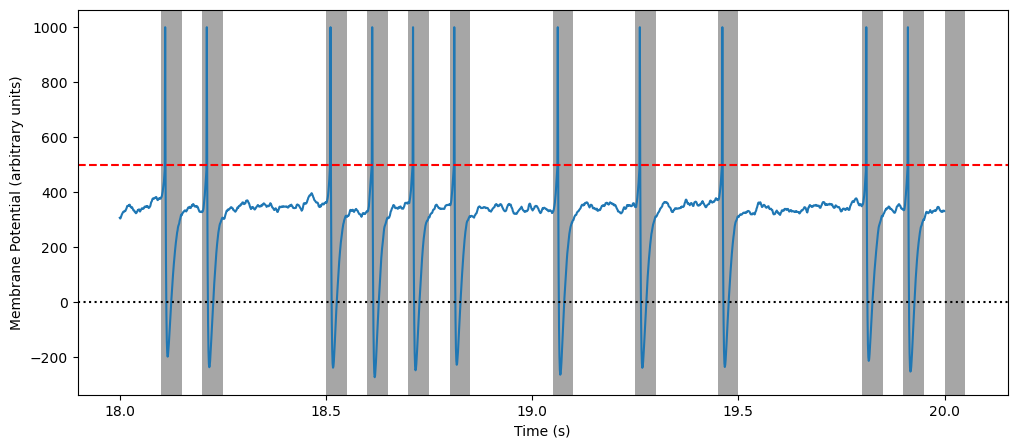

In [52]:
start_time = 18
end_time = 20

plot_potential(start_time, end_time, model, position_copypaste)

active neuron ration (w > 0.7): 14.9%


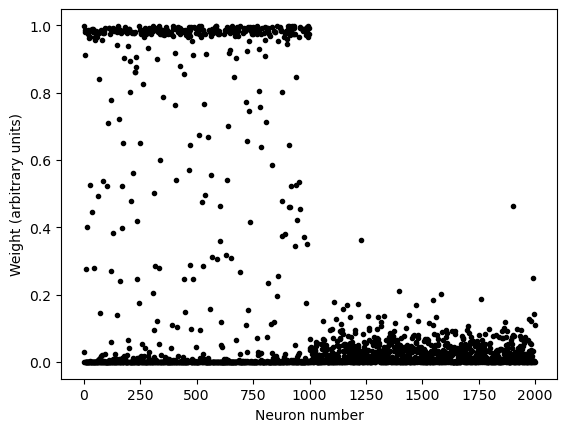

In [28]:
active_ration = np.sum(weight>0.7)/ len(weight) * 100
print(f'active neuron ration (w > 0.7): {active_ration:.1f}%')
plt.plot(np.arange(len(weight)), weight, '.k')
plt.xlabel('Neuron number')
plt.ylabel('Weight (arbitrary units)')
plt.show()

## Main Experiment

In [30]:
def save_data(path):
    np.save(path + "/weight.npy", weight)
    np.save(path + "/potential_rec.npy", model.potential_rec)
    np.save(path + "/spike_rec.npy", model.spike_rec)

# save_data('saved-data')

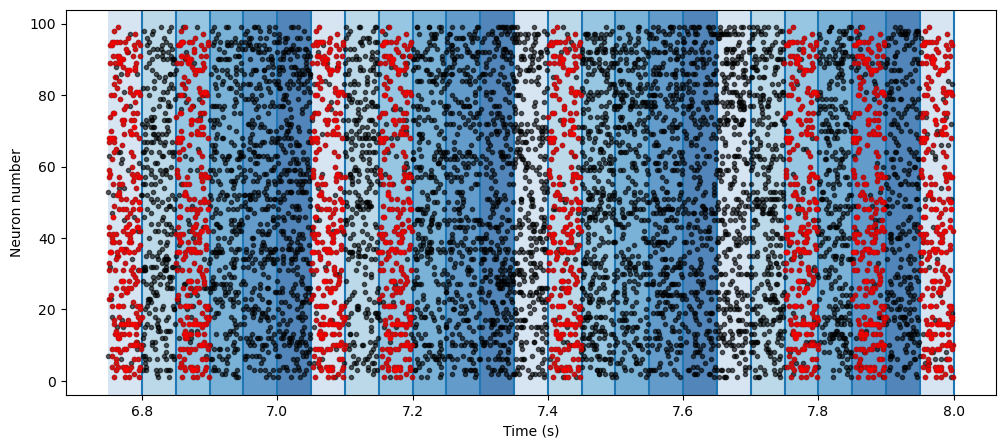

In [115]:
params = {'start_time' : 6.75,
        'end_time' : 8.0,
        'start_index' : 0,
        'end_index' : 100,}

plot_input(times, indices, params, times_pattern, indices_pattern)

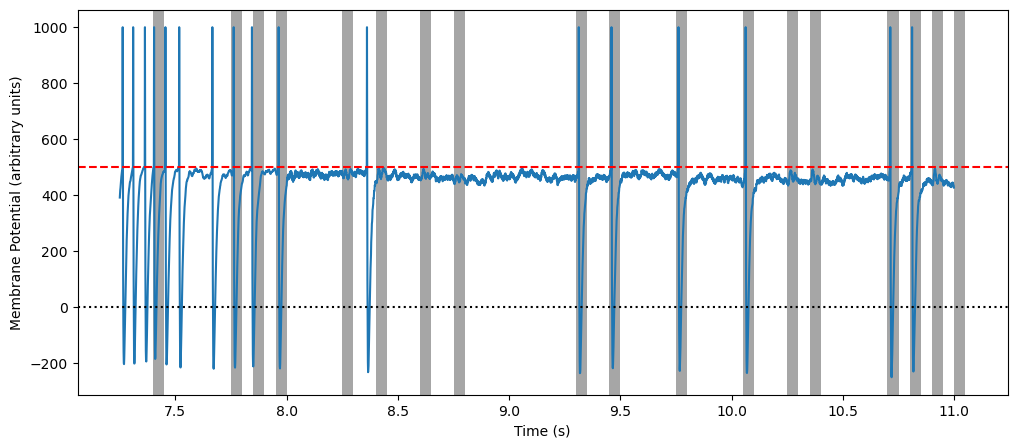

In [111]:
start_time = 7.25
end_time = 11

plot_potential(start_time, end_time, model, position_copypaste)

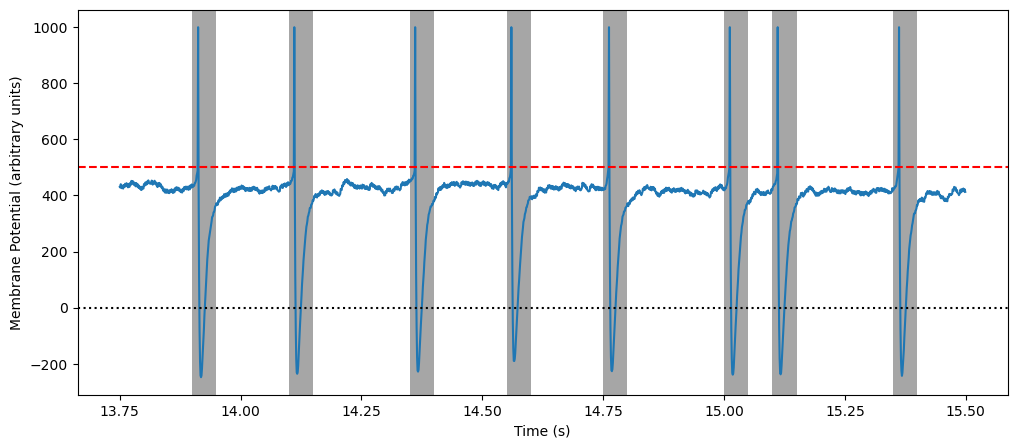

In [104]:
start_time = 13.75
end_time = 15.5

plot_potential(start_time, end_time, model, position_copypaste)

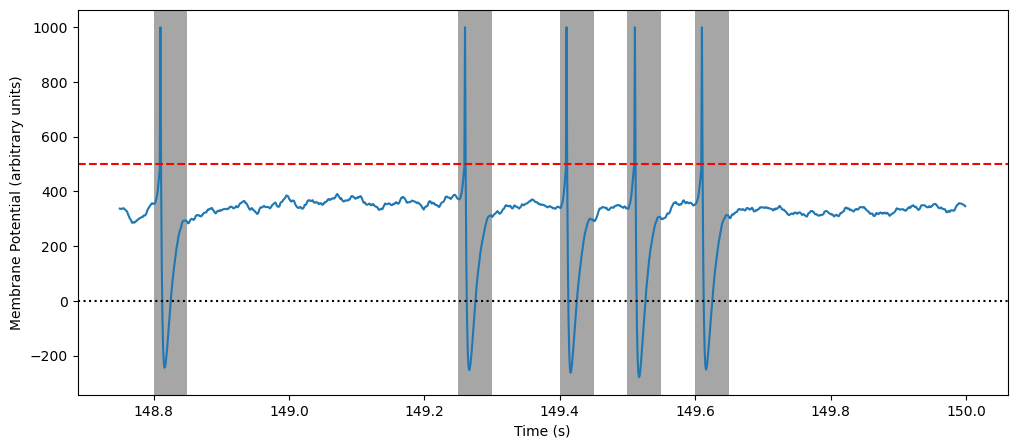

In [105]:
start_time = 148.75
end_time = 150

plot_potential(start_time, end_time, model, position_copypaste)

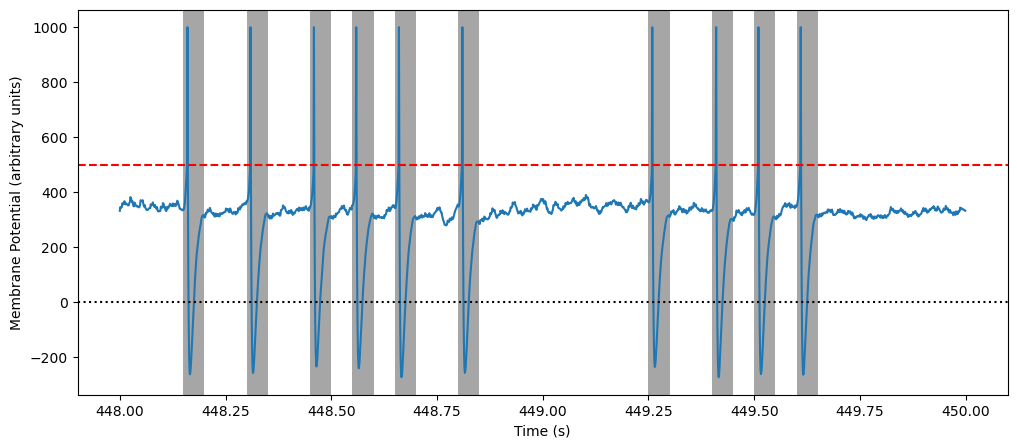

In [106]:
start_time = 448
end_time = 450.0

plot_potential(start_time, end_time, model, position_copypaste)

active neuron ration (w > 0.7): 16.4%


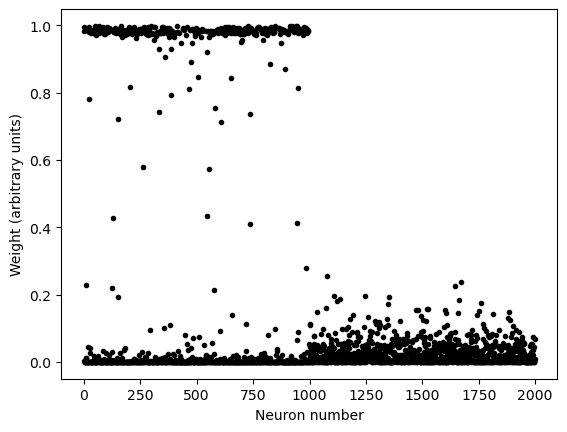

In [107]:
active_ration = np.sum(weight>0.7)/ len(weight) * 100
print(f'active neuron ration (w > 0.7): {active_ration:.1f}%')
plt.plot(np.arange(len(weight)), weight, '.k')
plt.xlabel('Neuron number')
plt.ylabel('Weight (arbitrary units)')
plt.show()

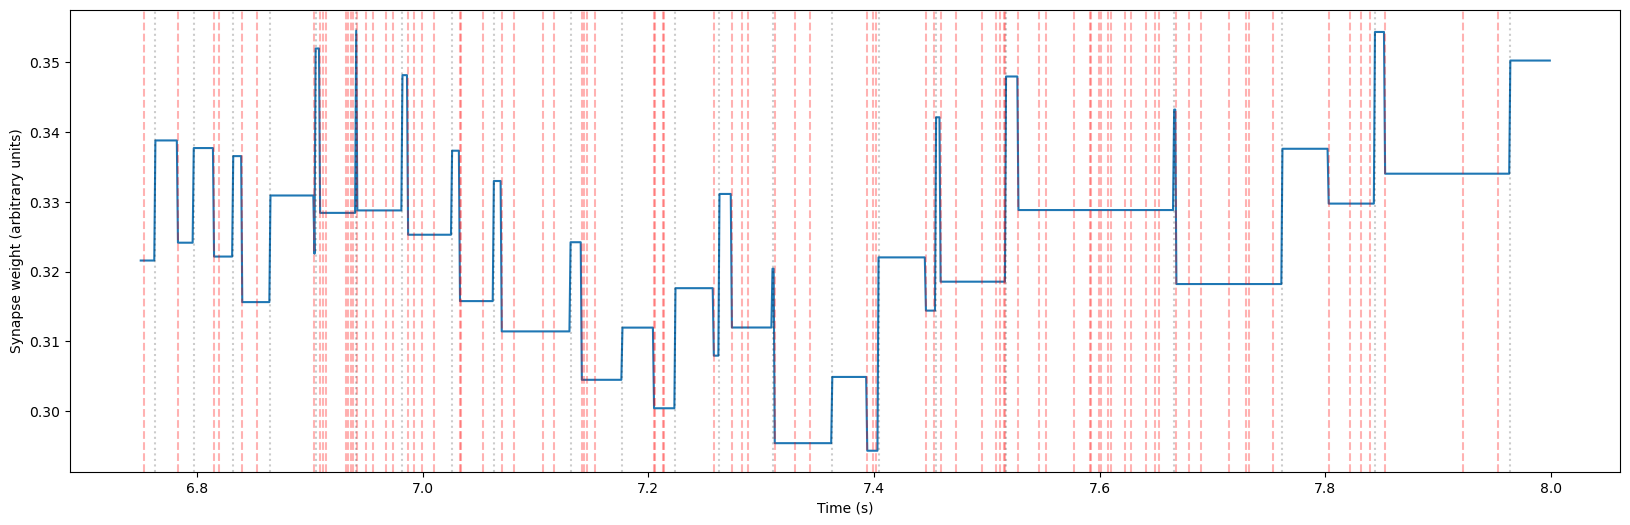

In [121]:
start_time = int(6.75 / dt)
end_time = int(8 / dt)
neuron0 = spike_train[0, start_time:end_time]
r = np.arange(start_time,end_time,1)

plt.figure(figsize=(20,6))
for i in range(1):
    plt.plot(r*dt, model.w_sample[i, start_time:end_time])

for x in np.where(neuron0 == 1)[0]:
    plt.axvline((x+start_time)*dt, color='red', linestyle='--', alpha=0.3, label='neuron 0 spike')

for spk in model.spike_rec:
    spk = int(spk/dt)
    if spk > start_time and spk < end_time:
        plt.axvline(spk*dt, color='black', linestyle=':', alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('Synapse weight (arbitrary units)')

plt.show()

In [143]:
threshold = 2.9
model_example = SRM(threshold=threshold, tau_m=tau_m, tau_s=tau_s, K1=K1, K2=K2,
            dt=dt, window_size=window_size, tref=tref, verbose=verbose, 
            A_pos= A_pos, B=B, tau_pos=tau_pos, tau_neg=tau_neg)

# ####### like in the paper fig.3
spike_train_example = np.zeros((2,75))
spike_train_example[0, [2,23,44,]] = 1
spike_train_example[1, [45,48,61,]] = 1
weight_example = np.array([1,1], dtype=float).reshape(-1,1)

model_example, weight_example = run_simulation(model_example, spike_train_example, weight_example)

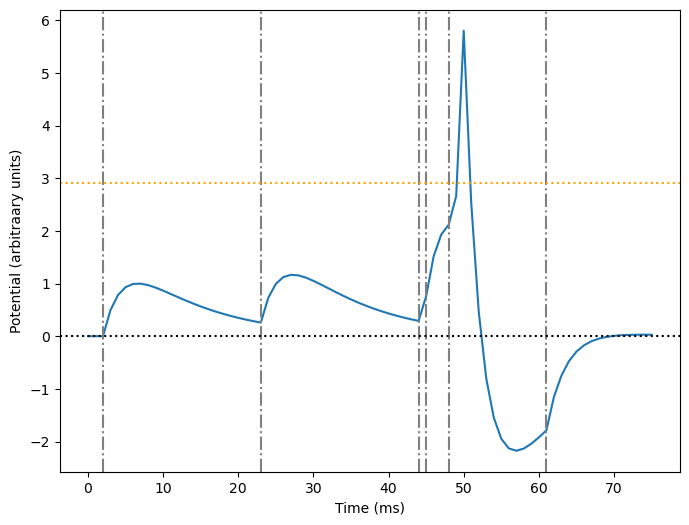

In [144]:
model_example.plot_membrane_potential_(spike_train_example)